In [1]:
import numpy as np
import xarray as xr
import yaml
from matplotlib import pyplot as plt, dates
from datetime import datetime, timedelta
from dateutil.parser import parse
from sklearn.neighbors import KernelDensity
from scipy import signal
from tqdm.notebook import tqdm

import NEMO_upwelling_postprocessing as ps

%matplotlib inline

In [2]:
plt.rcParams['font.size'] = 12

***

### Input parameters

In [22]:
# Upwelling events
events, runs = {}, {}
with open('parameters.yaml') as fn: events['N'], events['S'] = yaml.safe_load_all(fn)

params = {
    'N': np.arange(0.01, 0.0251, 0.0025),
    'u_wind': [5, 10, 15],
}

const = {
    'g': 9.81, 'f': 1.11e-4, 'N': 0.01, 'h_s': 10, 'H': 50, 'L_r': 1e4, 't': 86400,
    'rho_0': 1025, 'rho_s': 1020, 'rho_air': 1.23, 'C_d': 1e-3,
}

In [4]:
mask = xr.open_dataset('/data/bmoorema/MEOPAR/grid/mesh_mask201702.nc')
bathy = xr.open_dataset('/data/bmoorema/MEOPAR/grid/bathymetry_201702.nc')
grid_HRDPS = xr.open_dataset('https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSaAtmosphereGridV1')
HRDPS = xr.open_dataset('https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSaSurfaceAtmosphereFieldsV1')

In [5]:
bounds = [
    (1, 5),  # j = 375
    (1, 5),  # j = 380
    (1, 3),  # j = 385
    (1, 3),  # j = 390
    (1, 4),  # j = 395
    (1, 5),  # j = 400
    (1, 5),  # j = 405
    (1, 5),  # j = 410
    (1, 5),  # j = 415
    (1, 5),  # j = 420
    (1, 3),  # j = 425
    (1, 4),  # j = 435
    (1, 3),  # j = 440
    (1, 4),  # j = 445
    (1, 5),  # j = 450
    (1, 6),  # j = 455
    (1, 3),  # j = 465
    (1, 5),  # j = 470
    (1, 4),  # j = 475
    (1, 5),  # j = 480
    (1, 5),  # j = 495
    (1, 3),  # j = 500
    (1, 4),  # j = 505
    (1, 5),  # j = 510
    (1, 4),  # j = 520
    (1, 4),  # j = 525
    (2, 4),  # j = 530
    (1, 5),  # j = 535
    (1, 3),  # j = 540
    (1, 5),  # j = 545
    (1, 6),  # j = 550
    (1, 4),  # j = 555
    (1, 5),  # j = 560
    (1, 5),  # j = 565
    (1, 5),  # j = 570
    (1, 5),  # j = 575
    (1, 5),  # j = 580
    (1, 4),  # j = 585
    (1, 4),  # j = 590
    (1, 3),  # j = 605
    (1, 4),  # j = 610
    (1, 7),  # j = 620
    (1, 3),  # j = 625
    (1, 5),  # j = 630
    (1, 5),  # j = 655
    (1, 4),  # j = 660
    (1, 5),  # j = 665
    (1, 5),  # j = 670
    (1, 6),  # j = 675
    (1, 4),  # j = 680
    (1, 4),  # j = 685
    (1, 4),  # j = 690
    (1, 4),  # j = 695
    (1, 4),  # j = 700
    (1, 4),  # j = 705
    (1, 4),  # j = 710
    (1, 5),  # j = 715
]

***

### Process model results

Load along axis wind record

In [6]:
# Load results
wind = {'raw': [], 'filtered': []}
window = signal.get_window('blackman', 73)
for year in tqdm(range(2015, 2019)):
    
    # Load HRDPS
    fn = f'/ocean/bmoorema/research/MEOPAR/analysis-ben-hg/data/GEM25/HRDPS_ops_{year}0101_{year}1231.nc'
    with xr.open_dataset(fn) as ds:
        
        # Meshmask cut off inlets and JdF
        msk = ds.meshmask.values
        msk[:20, :20] = 0
        for lim in [(38, 48), (57, 30)]:
            msk[lim[0]:, lim[1]:] = 0
        msk = msk.reshape(-1).astype('bool')

        # Alongaxis wind
        u, v = [ds[var].values.reshape(-1, len(msk))[:, msk] for var in ['u_wind', 'v_wind']]
        jtau = np.sin(np.arctan2(v, u) - np.pi * (22 / 180))

        # Process and concatenate
        wind['raw'].append((jtau * np.sqrt(u**2 + v**2)).mean(axis=1))

# Concatenate and filter
wind['raw'] = np.hstack(wind['raw'])
wind['filtered'] = signal.convolve(wind['raw'], window / sum(window), mode='same')

# Time array
wind['time'] = np.array([datetime(2015, 1, 1) + timedelta(hours=h) for h in range(24*(365*4+1))])

Define section parameters

In [23]:
sections = ps.calc_coastline_indices(mask, bathy.Bathymetry, grid_HRDPS, const, filter_window=5, e1t_0=500)

/ocean/bmoorema/research/MEOPAR/SOG_upwelling_paper/notebooks/NEMO_upwelling_postprocessing.py:74: RuntimeWarning: invalid value encountered in greater
  index = np.array([bathy[y, x] for y, x in zip(j_s, i_s)]) > const['H']


Load runs

In [24]:
runs['idealized'] = ps.load_idealized(params, sections, mask, const, config='Nconst')

In [25]:
runs['hindcast'] = ps.load_hindcast(events['S'], sections, mask, const, HRDPS=HRDPS)

***

### Plot wind time series

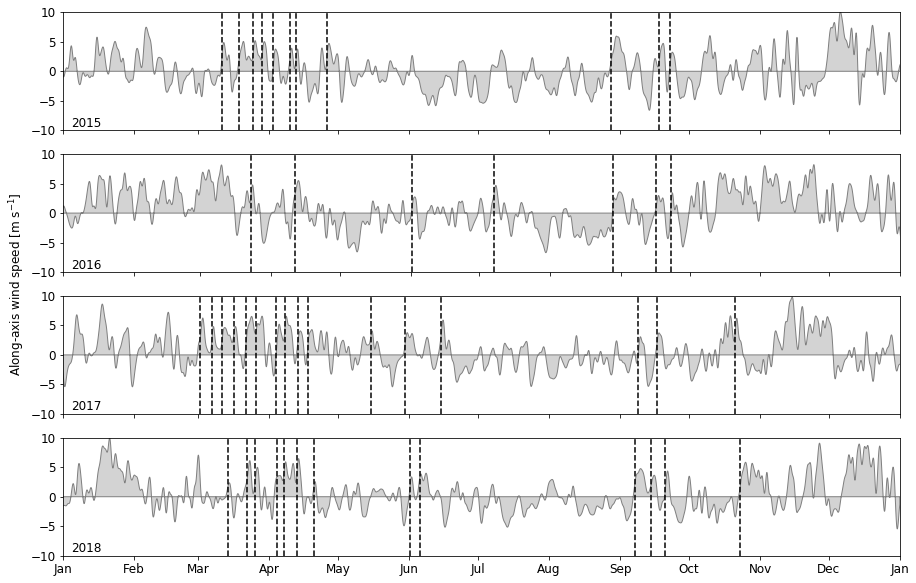

In [60]:
fig, axs = plt.subplots(4, 1, figsize=(15, 10))
ylim = [-10, 10]
axs[2].set_ylabel('Along-axis wind speed [m s$^{-1}$]', y=1.1)

for ax, year in zip(axs, range(2015, 2019)):
    
    ax.fill_between(wind['time'], wind['filtered'], facecolor='lightgray', edgecolor='gray')
    ax.set_xlim(datetime(year, 1, 1), datetime(year+1, 1, 1))
    ax.set_ylim(ylim)
    ax.text(0.01, 0.03, year, transform=ax.transAxes)
    ax.xaxis.set_major_locator(dates.MonthLocator())
    ax.xaxis.set_major_formatter(dates.DateFormatter('%b'))
    if year < 2018: ax.xaxis.set_ticklabels('')
    for date in events['S']:
        date = parse(date)
        ax.plot([date, date], ylim, 'k--')
        
fig.savefig('/home/bmoorema/Desktop/cttemtg_Dec2020/windevents.pdf', bbox_inches='tight')

***

### Manually calculate slope

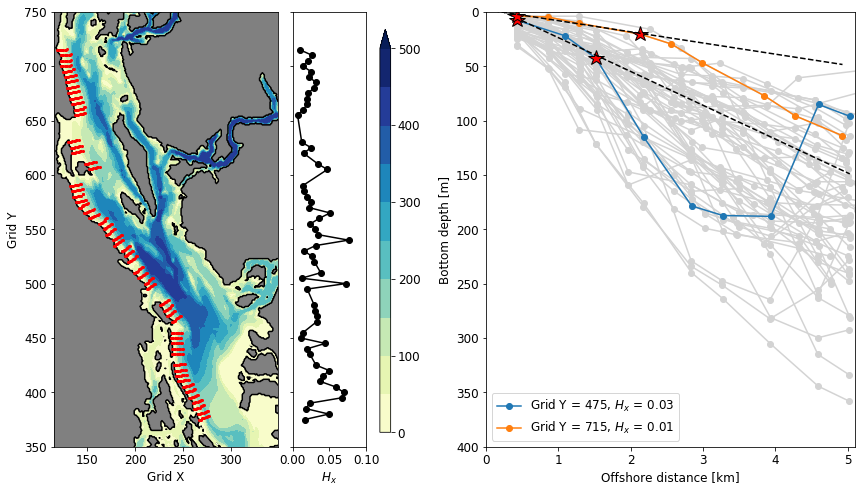

In [61]:
slope = []
jlist = sections['ji'][0][[18, 56]]

# Make figure
fig, axs = plt.subplots(1, 3, figsize=(15, 8), gridspec_kw={'wspace': 0.2, 'width_ratios': [4, 1, 5]})

# Plot map and bathymetry
c = axs[0].contourf(bathy.Bathymetry, levels=np.arange(0, 501, 50), cmap='YlGnBu', extend='max')
axs[0].contourf(mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='gray')
axs[0].contour(mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='k')
axs[0].set_xlim([115, 349])
axs[0].set_ylim([350, 750])
axs[0].set_aspect(5/4.4)
axs[0].set_xlabel('Grid X')
axs[0].set_ylabel('Grid Y')
cax = fig.add_axes([0.46, 0.15, 0.01, 0.7])
fig.colorbar(c, cax=cax)

# Loop through sections
for j, i, a, bound in zip(*sections['ji'], sections['angle'], bounds):
    
    # Extract section coordinates
    e1t, e2t = [float(mask[var][0, j, i]) for var in ['e1t', 'e2t']]
    coords = []
    for coord, var, func, oper in zip([i, j], [e1t, e2t], ['cos', 'sin'], ['add', 'subtract']):
        d = 5e3 / var * getattr(np, func)(a)
        coords.append(np.linspace(coord, getattr(np, oper)(coord, d), 10, dtype=int))
    
    # Plot coordinates on map and build bathymetry section
    transect = []
    for x, y in zip(*coords):
        axs[0].plot(x, y, 'ro', markersize=2)
        transect.append(float(bathy.Bathymetry[y, x]))
    
    # Build offshore distance array and plot bathymetry section
    dx, dy = [np.diff(coord, prepend=coord[0]) for coord in coords]
    x = 1e-3 * np.cumsum(np.sqrt((dx*e1t)**2 + (dy*e2t)**2))
    axs[2].plot(x, transect, 'o-', color='lightgray', zorder=0)
    
    # Calculate slope from linear regression
    slc = slice(*bound)
    b1 = np.corrcoef(x[slc], transect[slc])[0, 1] * np.std(transect[slc]) / np.std(x[slc])
    b0 = np.mean(transect[slc]) - b1 * np.mean(x[slc])
    slope.append(1e-3 * b1)
    
    # Overlay selected sections
    if j in jlist:
        axs[2].plot(x, transect, 'o-', zorder=1, label=f'Grid Y = {j}, $H_x$ = {1e-3*b1:.2f}')
        for bnd, shift in zip(bound, [0, 1]):
            axs[2].plot(x[bnd-shift], transect[bnd-shift], 'r*', zorder=1, markersize=16, markeredgecolor='k')
        axs[2].plot(x, b0 + b1 * x, 'k--', zorder=1)

# Formatting
axs[2].set_xlim([0, 5.1])
axs[2].set_ylim([400, 0])
axs[2].set_xlabel('Offshore distance [km]')
axs[2].set_ylabel('Bottom depth [m]')
axs[2].legend()

# Plot slope
axs[1].plot(slope, sections['ji'][0], 'ko-')
axs[1].set_xlim([0, 0.1])
axs[1].set_ylim([350, 750])
axs[1].set_xlabel('$H_x$')
axs[1].yaxis.set_ticklabels('')
pos = axs[1].get_position()
axs[1].set_position([pos.x0-0.065, pos.y0, pos.width, pos.height])

fig.savefig('/home/bmoorema/Desktop/cttemtg_Dec2020/slope.pdf', bbox_inches='tight')

***

### Calculate Choboter parameters

In [28]:
for run, nruns in zip(['idealized', 'hindcast'], [21, len(events['S'])]):
    slope_runs = []
    for n in range(nruns):
        slope_runs.append(slope)
    slope_runs = np.hstack(slope_runs)
    L_R = runs[run]['N'] * const['H'] / const['f']
    S = slope_runs * runs[run]['N'] / const['f']
    mu = np.arctan(S)
    T = const['rho_0'] * const['f'] * L_R * const['H'] / runs[run]['tau_along']
    exp = 1 - np.exp(-2 * mu * const['t'] / T)
    S_ratio = 2 * S**2 / (1 + S**2)
    runs[run]['h_u_pred'] = const['H'] * np.arccos(1 - S_ratio * exp) / (2 * mu)
    runs[run]['S'] = S
    runs[run]['tT'] = const['t'] / T

/home/bmoorema/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in arccos
  if sys.path[0] == '':


***

### Parameter space plots

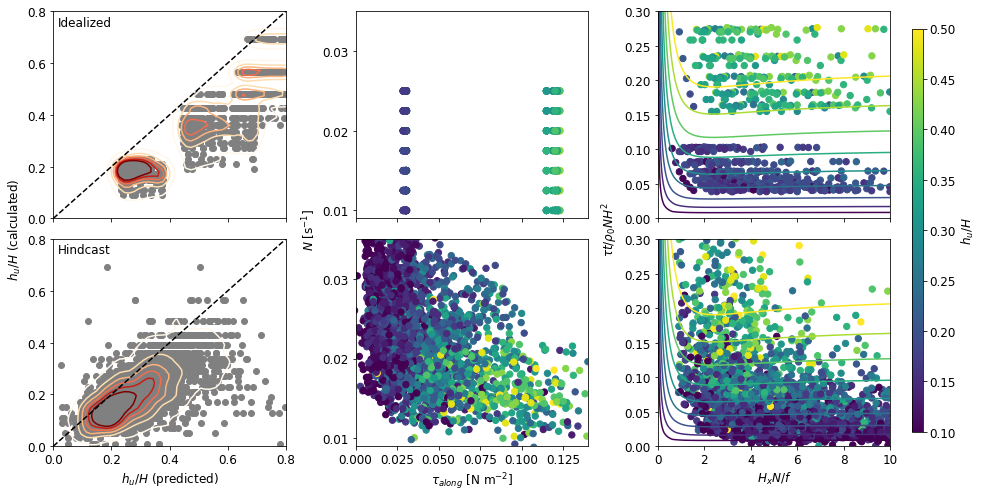

In [62]:
# Make plot area
fig, axs = plt.subplots(2, 3, figsize=(15, 8), gridspec_kw={'hspace': 0.1, 'wspace': 0.3})

# Make Choboter parameter space function for plotting
S_grid, t_grid = np.meshgrid(np.arange(0.01, 10.1, 0.01), np.arange(0, 0.61, 0.01))
mu = np.arctan(S_grid)
exp = 1 - np.exp(-2 * mu * t_grid)
S_ratio = 2 * S_grid**2 / (1 + S_grid**2)
hu_grid = np.arccos(1 - S_ratio * exp) / (2 * mu)

# Loop through runtypes
for row, run in zip(axs, ['idealized', 'hindcast']):
    
    # Predicted vs calculated
    row[0].plot(runs[run]['h_u_pred']/const['H'], runs[run]['h_u']/const['H'], 'o', color='gray')
    row[0].plot([0, 1], [0, 1], 'k--', zorder=11)
    row[0].set_xlim([0, 0.8])
    row[0].set_ylim([0, 0.8])
    row[0].yaxis.set_ticks([0, 0.2, 0.4, 0.6, 0.8])
    row[0].text(0.02, 0.93, run.capitalize(), transform=row[0].transAxes)
    
    # Add KDE
    index = ~np.isnan(runs[run]['h_u_pred'])
    grid = np.linspace(0, 0.8, 50)
    xy_data = np.vstack([runs[run]['h_u_pred'][index]/const['H'], runs[run]['h_u'][index]/const['H']]).T
    xy_grid = np.vstack([dim.ravel() for dim in np.meshgrid(grid, grid)]).T
    kde = KernelDensity(kernel='gaussian', bandwidth=0.02)
    z = np.exp(kde.fit(xy_data).score_samples(xy_grid)).reshape((50, 50))
    row[0].contour(grid, grid, z, levels=np.array([1, 4, 7, 10, 13, 16]), zorder=10, cmap='OrRd')

    # tau-N space
    c = row[1].scatter(
        runs[run]['tau_along'], runs[run]['N'], s=40, c=runs[run]['h_u']/const['H'], vmin=0.1, vmax=0.5,
    )
    row[1].set_xlim([0, 0.14])
    row[1].set_ylim([0.009, 0.035])
    row[1].yaxis.set_ticks([0.01, 0.02, 0.03])
        
    # S-T space
    c = row[2].scatter(runs[run]['S'], runs[run]['tT'], s=40, c=runs[run]['h_u']/const['H'], vmin=0.1, vmax=0.5)
    row[2].contour(S_grid, t_grid, hu_grid, levels=np.arange(0.1, 0.51, 0.05))
    row[2].set_xlim([0, 10])
    row[2].set_ylim([0, 0.3])
    row[2].yaxis.set_ticks([0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3])
    
    # Formatting
    if run == 'hindcast':
        row[0].set_xlabel('$h_u/H$ (predicted)')
        row[1].set_xlabel('$\\tau_{along}$ [N m$^{-2}$]')
        row[2].set_xlabel('$H_xN/f$')
        row[0].set_ylabel('$h_u/H$ (calculated)', y=1.05)
        row[1].set_ylabel('$N$ [s$^{-1}$]', y=1.05)
        row[2].set_ylabel('$\\tau t/\\rho_0NH^2$', y=1.05)
    else:
        for ax in row: ax.xaxis.set_ticklabels('')

cax = fig.add_axes([0.92, 0.15, 0.01, 0.7])
fig.colorbar(c, cax=cax, label='$h_u/H$')

fig.savefig('/home/bmoorema/Desktop/cttemtg_Dec2020/parameterspace.pdf', bbox_inches='tight')

***

### Along-axis plots

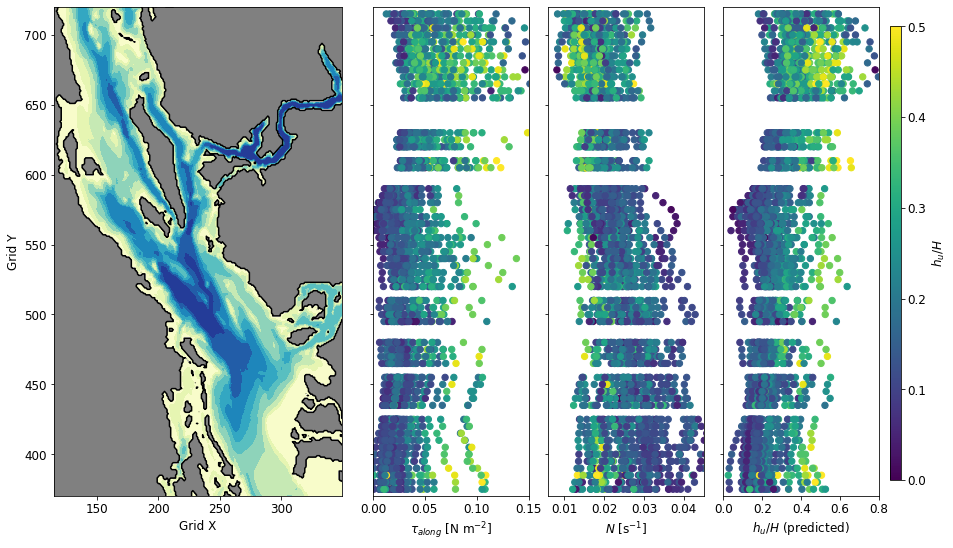

In [63]:
# Make figure
fig, axs = plt.subplots(1, 4, figsize=(15, 9), gridspec_kw={'wspace': 0.1, 'width_ratios': [2, 1, 1, 1]})

# Plot map and bathymetry
c = axs[0].contourf(bathy.Bathymetry, levels=np.arange(0, 501, 50), cmap='YlGnBu', extend='max')
axs[0].contourf(mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='gray')
axs[0].contour(mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='k')
axs[0].set_xlim([115, 349])
axs[0].set_ylim([370, 720])
axs[0].set_aspect(5/4.4)
axs[0].set_xlabel('Grid X')
axs[0].set_ylabel('Grid Y')

xlabels = ['$\\tau_{along}$ [N m$^{-2}$]', '$N$ [s$^{-1}$]', '$h_u/H$ (predicted)']
for ax, var, xlim, xlabel in zip(axs[1:], ['tau_along', 'N', 'h_u_pred'], [(0, 0.15), (0.006, 0.045), (0, 0.8)], xlabels):
    norm = const['H'] if var == 'h_u_pred' else 1
    c = ax.scatter(
        runs['hindcast'][var]/norm, runs['hindcast']['j'], s=40, c=runs['hindcast']['h_u']/const['H'], vmin=0, vmax=0.5,
    )
    ax.set_xlim(xlim)
    ax.set_ylim([370, 720])
    ax.set_xlabel(xlabel)
    ax.yaxis.set_ticklabels('')

cax = fig.add_axes([0.91, 0.15, 0.01, 0.7])
fig.colorbar(c, cax=cax, label='$h_u/H$')

fig.savefig('/home/bmoorema/Desktop/cttemtg_Dec2020/spatialdependence.pdf', bbox_inches='tight')